# Projet de prédiction des données liées au Covid

Imports

In [90]:
import pandas as pd
import matplotlib.pyplot as plt

import plotly.io as pio
pio.renderers.default = 'iframe_connected'

ModuleNotFoundError: No module named 'plotly'

In [57]:
df_raw_confirmed_global = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
df_raw_deaths_global = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df_raw_vaccination_global = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv")
df_raw_vaccination_global=df_raw_vaccination_global.drop(columns=["daily_vaccinations_per_million","total_boosters_per_hundred","daily_vaccinations_raw","total_boosters","people_fully_vaccinated_per_hundred","daily_people_vaccinated_per_hundred","people_vaccinated", "total_vaccinations", "daily_vaccinations", "people_fully_vaccinated","total_vaccinations_per_hundred","people_vaccinated_per_hundred"])


In [58]:
# Choose latitude and longitude for the chosen country
lat_min = 41.317
lat_max = 51.07167
long_min = -5.14028
long_max = 9.51333

In [59]:
# Function to filter elements by latitude/longitude
def check_lat_long(df, lat_min, lat_max, long_min, long_max):
   return df[(df["Lat"] > lat_min) & (df["Lat"] < lat_max) & (df["Long"] > long_min) & (df["Long"] < long_max)]

In [60]:
country = "France"

df_raw_confirmed_country = df_raw_confirmed_global[df_raw_confirmed_global["Country/Region"] == country]
df_raw_deaths_country = df_raw_deaths_global[df_raw_deaths_global["Country/Region"] == country]
df_raw_vaccination_country = df_raw_vaccination_global[df_raw_vaccination_global["location"] == country]
#df_confirmed_country = df_raw_confirmed_country
#df_deaths_country = df_raw_deaths_country
df_confirmed_country = check_lat_long(df_raw_confirmed_country, lat_min ,lat_max ,long_min, long_max)
df_deaths_country = check_lat_long(df_raw_deaths_country, lat_min, lat_max, long_min, long_max)

In [61]:
uselessColumns = ["Lat", "Long", "Province/State", "Country/Region"]

def columnsInNumbers(df):
  df.columns = [i for i in range(len(df_confirmed_country.columns))]

df_confirmed_country = df_confirmed_country.drop(columns=uselessColumns)
df_deaths_country = df_deaths_country.drop(columns=uselessColumns)

columnsInNumbers(df_confirmed_country)
columnsInNumbers(df_deaths_country)


df_confirmed_country

,0,1,2,3,4,5,6,7,8,9,...,666,667,668,669,670,671,672,673,674,675
130,0,0,2,3,3,3,4,5,5,5,...,7168026,7188721,7211399,7231148,7235966,7266361,7296757,7330086,7364380,7364380


In [62]:
def get_values_and_days(df):
  return (df.values[0], df.columns.to_list())

confirmed_country_values, confirmed_country_days = get_values_and_days(df_confirmed_country)
deaths_country_values, deaths_country_days = get_values_and_days(df_deaths_country)
vaccination_index_values = list(df_raw_vaccination_country.daily_people_vaccinated)[:len(confirmed_country_values)]
vaccination_index_days = [i for i in range(df_raw_vaccination_country.date.size)]


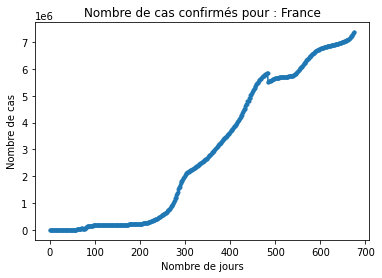

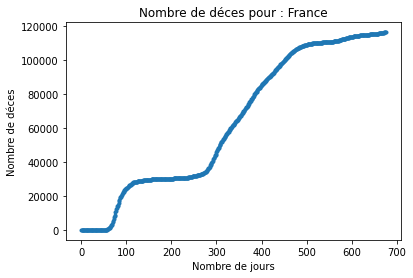

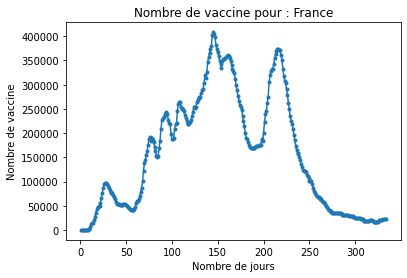

In [63]:
plt.plot(confirmed_country_days, confirmed_country_values, '.-')
plt.title("Nombre de cas confirmés pour : " + country)
plt.xlabel("Nombre de jours")
plt.ylabel("Nombre de cas")
plt.show()

plt.plot(deaths_country_days, deaths_country_values, '.-')
plt.title("Nombre de déces pour : " + country)
plt.xlabel("Nombre de jours")
plt.ylabel("Nombre de déces")
plt.show()

plt.plot(vaccination_index_days, vaccination_index_values, '.-')
plt.title("Nombre de vaccine pour : " + country)
plt.xlabel("Nombre de jours")
plt.ylabel("Nombre de vaccine")
plt.show()

Training and test sets


In [64]:
from sklearn.model_selection import train_test_split

confirmed_train, confirmed_test, confirmed_train_days, confirmed_test_days = train_test_split(confirmed_country_values, confirmed_country_days, test_size=0.30, shuffle=False)
deaths_train, deaths_test, deaths_train_days, deaths_test_days = train_test_split(deaths_country_values, deaths_country_days, test_size=0.30, shuffle=False)

# Regression polynomiale (degré = 2)

In [65]:
import numpy as np
from sklearn import svm

In [66]:
def regression(X, Y):
  reg = svm.SVR(kernel='poly', C=1000, degree=2)
  reg.fit(X, Y)
  return reg

reg_confirmed = regression(np.reshape(confirmed_train_days, newshape=(-1, 1)), confirmed_train)
reg_deaths = regression(np.reshape(deaths_train_days, newshape=(-1, 1)), deaths_train)

print("Regression cas : ", reg_confirmed.score(np.reshape(confirmed_test_days, newshape=(-1, 1)), confirmed_test))
print("Regression morts : ", reg_deaths.score(np.reshape(deaths_test_days, newshape=(-1, 1)), deaths_test))

Regression cas :  -7.018829295450718
Regression morts :  -422.13088428886044


Visualisation des modèles

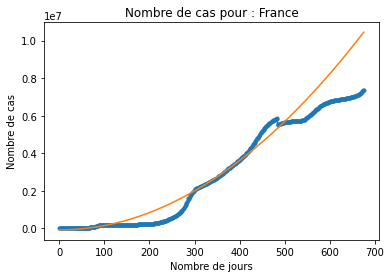

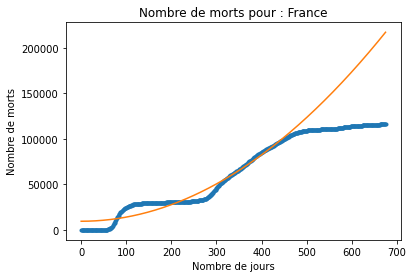

In [67]:
def display_plot(reg, X, Y, ord_context):
  plt.plot(X, Y, '.-')
  plt.plot(X, reg.predict(X), "-")
  plt.title("Nombre de " + ord_context + " pour : " + country)
  plt.xlabel("Nombre de jours")
  plt.ylabel("Nombre de " + ord_context)
  plt.show()

display_plot(reg_confirmed, np.reshape(confirmed_country_days, newshape=(-1, 1)), confirmed_country_values, "cas")
display_plot(reg_deaths, np.reshape(deaths_country_days, newshape=(-1, 1)), deaths_country_values, "morts")

# Réseaux LSTM

In [68]:
import tensorflow as tf
import keras as kr
from sklearn.preprocessing import MinMaxScaler

In [69]:
def create_sequences(data, time_steps=1):
  dataX, dataY = [], []
  for i in range(len(data)-time_steps):
    a = data[i:(i+time_steps)]
    dataX.append(a)
    dataY.append(data[i + time_steps][0])
  return np.array(dataX), np.array(dataY)

def create_lstm_sets(X, time_steps=1, scale=True, train_percent=0.75):
  scaler=None
  if scale:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(X)
    scaled_X = scaler.transform(X)
  else:
    scaled_X = np.array(X)
  train_size = int(len(scaled_X) * train_percent)
  test_size = len(scaled_X) - train_size
  train, test = scaled_X[0:train_size,:], scaled_X[train_size:len(scaled_X),:]
  return create_sequences(train, time_steps), create_sequences(test, time_steps), scaler

def lstm_network(X, Y, time_steps=1, n_features=1):
  model = kr.Sequential()
  model.add(kr.layers.LSTM(100, input_shape=(time_steps, n_features), return_sequences=True)) #return_sequences=True
  model.add(kr.layers.Dropout(0.3))
  model.add(kr.layers.LSTM(100))
  model.add(kr.layers.Dropout(0.3))
  model.add(kr.layers.Dense(1))
  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss='mean_squared_error', optimizer=opt)
  model.summary()
  model.fit(X, Y, epochs=50, batch_size=6);
  return model

## Variable monodimensionelle

In [70]:
time_steps = 1
n_features = 1

### Nombre de cas

In [71]:
confirmed_lstm_set = df_confirmed_country.values[0]
confirmed_lstm_set = np.reshape(confirmed_lstm_set, (len(confirmed_lstm_set), 1))

confirmed_train, confirmed_test, confirmed_scaler = create_lstm_sets(confirmed_lstm_set, time_steps)

confirmed_trainX, confirmed_trainY = confirmed_train
confirmed_testX, confirmed_testY = confirmed_test

confirmed_lstm = lstm_network(confirmed_trainX, confirmed_trainY, time_steps)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1, 100)            40800     
                                                                 
 dropout_8 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_9 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
85/85 [==============================

### Nombre de morts

In [72]:
deaths_lstm_set = df_deaths_country.values[0]
deaths_lstm_set = np.reshape(deaths_lstm_set, (len(deaths_lstm_set), 1))

deaths_train, deaths_test, deaths_scaler = create_lstm_sets(deaths_lstm_set, time_steps)
deaths_trainX, deaths_trainY = deaths_train
deaths_testX, deaths_testY = deaths_test

deaths_lstm = lstm_network(deaths_trainX, deaths_trainY, time_steps)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 1, 100)            40800     
                                                                 
 dropout_10 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_11 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_11 (Dropout)        (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
85/85 [==============================

### Affichage des résultats

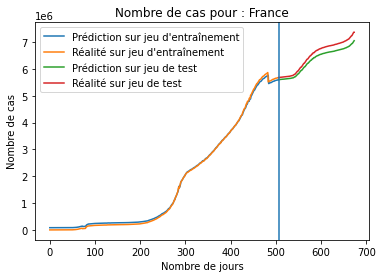

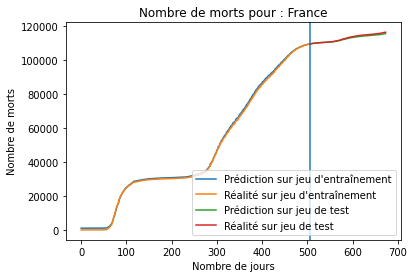

In [73]:
def display_plot_lstm(model, scaler, trainX, trainY, testX, testY, country, ord_context):
  daysTrain = range(len(trainX))
  daysTest = np.array(range(len(testX))) + len(daysTrain)
  plt.plot(daysTrain, scaler.inverse_transform(model.predict(trainX)), '-', label="Prédiction sur jeu d'entraînement")
  plt.plot(daysTrain, scaler.inverse_transform(np.reshape(trainY, (-1, 1))), '-', label="Réalité sur jeu d'entraînement")

  plt.plot(daysTest, scaler.inverse_transform(model.predict(testX)), '-', label="Prédiction sur jeu de test")
  plt.plot(daysTest, scaler.inverse_transform(np.reshape(testY, (-1, 1))), '-', label="Réalité sur jeu de test")

  plt.axvline(len(trainX), 0, 1)
  plt.legend()
  plt.title("Nombre de " + ord_context + " pour : " + country)
  plt.xlabel("Nombre de jours")
  plt.ylabel("Nombre de " + ord_context)
  plt.show()

display_plot_lstm(confirmed_lstm, confirmed_scaler, confirmed_trainX, confirmed_trainY, confirmed_testX, confirmed_testY, country, "cas")
display_plot_lstm(deaths_lstm, deaths_scaler, deaths_trainX, deaths_trainY, deaths_testX, deaths_testY, country, "morts")

In [74]:
days = 60
predictions = []
test = [[0.5]]
print(test)
start_day = len(confirmed_trainX)
print(start_day)
for i in range(days):
    pred = confirmed_lstm.predict(test)
    predictions.append(pred)
    test = pred
    print(test)

[[0.5]]
506
[[0.48258525]]
[[0.4666406]]
[[0.45199418]]
[[0.4385]]
[[0.42603445]]
[[0.41449094]]
[[0.4037773]]
[[0.39381373]]
[[0.38453048]]
[[0.37586623]]
[[0.3677665]]
[[0.3601836]]
[[0.3530749]]
[[0.34640235]]
[[0.34013164]]
[[0.33423245]]
[[0.32867676]]
[[0.32343984]]
[[0.31849873]]
[[0.31383312]]
[[0.30942386]]
[[0.30525404]]
[[0.30130798]]
[[0.29757112]]
[[0.29403007]]
[[0.29067275]]
[[0.2874879]]
[[0.28446507]]
[[0.28159472]]
[[0.27886796]]
[[0.27627623]]
[[0.27381203]]
[[0.27146807]]
[[0.26923764]]
[[0.2671146]]
[[0.26509303]]
[[0.26316747]]
[[0.26133287]]
[[0.2595844]]
[[0.2579176]]
[[0.25632834]]
[[0.2548124]]
[[0.25336617]]
[[0.25198624]]
[[0.25066918]]
[[0.24941194]]
[[0.24821147]]
[[0.24706513]]
[[0.24597022]]
[[0.24492428]]
[[0.24392492]]
[[0.2429699]]
[[0.24205726]]
[[0.24118486]]
[[0.24035081]]
[[0.23955342]]
[[0.23879102]]
[[0.23806188]]
[[0.23736432]]
[[0.23669726]]


# Variables multi-dimensionnelles

In [75]:
time_steps = 2
n_features = 2

### Get new data


In [76]:
df_raw_stringency_index = pd.read_csv("covid-stringency-index.csv")
df_raw_stringency_index_country = df_raw_stringency_index[df_raw_stringency_index["Entity"] == country]
df_stringency_index_country = df_raw_stringency_index_country.drop(columns=["Entity", "Code"])
df_stringency_index_country.drop(index=df_stringency_index_country.index[0], axis=0, inplace=True)

stringency_index_values = list(df_stringency_index_country.stringency_index)[:len(confirmed_country_values)]
stringency_index_days = [i for i in range(df_stringency_index_country.Day.size)]

### Adjust some data length (all equal)

In [77]:
confirmed_country_values = confirmed_country_values[:len(stringency_index_values)]
confirmed_country_days = confirmed_country_days[:len(stringency_index_values)]

deaths_country_values = deaths_country_values[:len(stringency_index_values)]
deaths_country_days = deaths_country_days[:len(stringency_index_values)]

### Print on a plot

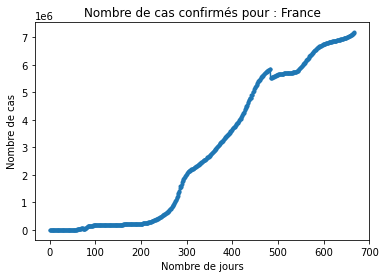

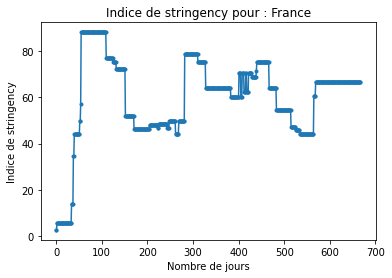

In [78]:
plt.plot(confirmed_country_days, confirmed_country_values, '.-')
plt.title("Nombre de cas confirmés pour : " + country)
plt.xlabel("Nombre de jours")
plt.ylabel("Nombre de cas")
plt.show()

plt.plot(stringency_index_days, stringency_index_values, '.-')
plt.title("Indice de stringency pour : " + country)
plt.xlabel("Nombre de jours")
plt.ylabel("Indice de stringency")
plt.show()

### Create data sets

In [79]:
# Scaled values
confirmed_scaler = MinMaxScaler((-1, 1))
deaths_scaler = MinMaxScaler((-1, 1))
stringency_scaler = MinMaxScaler((-1, 1))

confirmed_scaler.fit(confirmed_country_values.reshape((-1, 1)))
scaled_confirmed = confirmed_scaler.transform(confirmed_country_values.reshape((-1, 1))).reshape((-1,))

deaths_scaler.fit(deaths_country_values.reshape((-1, 1)))
scaled_deaths = deaths_scaler.transform(deaths_country_values.reshape((-1, 1))).reshape((-1,))

stringency_scaler.fit(np.array(stringency_index_values).reshape((-1, 1)))
scaled_stringency = stringency_scaler.transform(np.array(stringency_index_values).reshape((-1, 1))).reshape((-1,))

In [80]:
multi_data = list(zip(scaled_confirmed, scaled_stringency))

In [81]:
multi_train, multi_test, _ = create_lstm_sets(multi_data, time_steps, scale=False, train_percent=0.70)
multi_trainX, multi_trainY = multi_train
multi_testX, multi_testY = multi_test

In [82]:
def lstm_network_multi(X, Y, time_steps=1, n_features=1):
  model = kr.Sequential()
  model.add(kr.layers.LSTM(100, input_shape=(time_steps, n_features), return_sequences=True)) #return_sequences=True
  model.add(kr.layers.Dropout(0.2))
  model.add(kr.layers.LSTM(100))
  model.add(kr.layers.Dropout(0.2))
  model.add(kr.layers.Dense(1))
  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss='mean_squared_error', optimizer=opt)
  model.summary()
  model.fit(X, Y, epochs=30, batch_size=6);
  return model

In [83]:
multi_lstm = lstm_network_multi(multi_trainX, multi_trainY, time_steps, n_features)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 2, 100)            41200     
                                                                 
 dropout_12 (Dropout)        (None, 2, 100)            0         
                                                                 
 lstm_13 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_13 (Dropout)        (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121,701
Trainable params: 121,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
78/78 [==============================

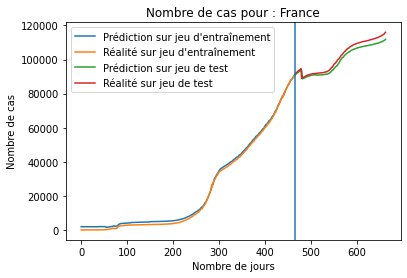

In [84]:
display_plot_lstm(multi_lstm, deaths_scaler, multi_trainX, multi_trainY, multi_testX, multi_testY, country, "cas")

In [85]:
n_days = 150
predictions = []
test = multi_trainX[-1]
test = test.reshape(-1, time_steps, n_features)
start_day = len(multi_trainX)
print(start_day)
for i in range(n_days):
    pred = multi_lstm.predict(test)
    predictions.append(pred[0][0])
    
    old = test[0][0]
    test = np.delete(test[0], 0, axis=0)

    test = np.append(test, [pred[0][0], old[1]]).reshape(-1, time_steps, n_features)

    print(pred)

465
[[0.55741394]]
[[0.5621316]]
[[0.5633979]]
[[0.56681406]]
[[0.5684821]]
[[0.57113665]]
[[0.5728809]]
[[0.5750509]]
[[0.57672536]]
[[0.5785579]]
[[0.58010316]]
[[0.58168143]]
[[0.58307874]]
[[0.58445364]]
[[0.58570343]]
[[0.5869079]]
[[0.5880191]]
[[0.58907783]]
[[0.5900624]]
[[0.59099424]]
[[0.59186465]]
[[0.5926856]]
[[0.59345376]]
[[0.594177]]
[[0.59485453]]
[[0.5954918]]
[[0.59608936]]
[[0.5966505]]
[[0.5971769]]
[[0.59767085]]
[[0.5981349]]
[[0.5985697]]
[[0.59897804]]
[[0.599361]]
[[0.5997201]]
[[0.6000573]]
[[0.6003736]]
[[0.6006701]]
[[0.6009487]]
[[0.60120946]]
[[0.60145444]]
[[0.60168403]]
[[0.60189945]]
[[0.60210127]]
[[0.6022906]]
[[0.6024683]]
[[0.602635]]
[[0.6027912]]
[[0.6029378]]
[[0.6030751]]
[[0.60320413]]
[[0.6033247]]
[[0.60343814]]
[[0.60354435]]
[[0.6036439]]
[[0.60373724]]
[[0.60382473]]
[[0.6039068]]
[[0.60398376]]
[[0.604056]]
[[0.60412335]]
[[0.60418683]]
[[0.60424614]]
[[0.604302]]
[[0.60435426]]
[[0.6044034]]
[[0.6044491]]
[[0.60449237]]
[[0.6045326]]
[[

In [86]:
predicted_plot = np.concatenate((confirmed_trainX[:start_day].reshape((-1,)), predictions))
predicted_plot = confirmed_scaler.inverse_transform(predicted_plot.reshape((-1, 1)))

days = np.concatenate((list(range(start_day)), np.array([day for day in range(start_day, start_day+n_days)])))

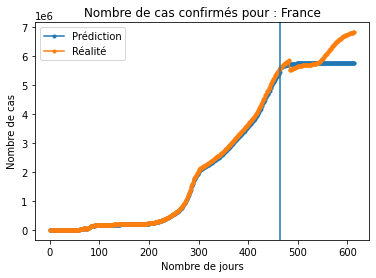

In [87]:
plt.plot(days, predicted_plot, '.-', label="Prédiction")
plt.plot(days, confirmed_country_values[:start_day+n_days], '.-', label="Réalité")
plt.legend()
plt.axvline(start_day)
plt.title("Nombre de cas confirmés pour : " + country)
plt.xlabel("Nombre de jours")
plt.ylabel("Nombre de cas")
plt.show()